In [12]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import sheet_unfolding.sim as sim
from matplotlib.colors import LogNorm


# First run the simulation

integrate time 2.0000e-02 -> 1.0000e+00  with da=0.001  (980 steps)


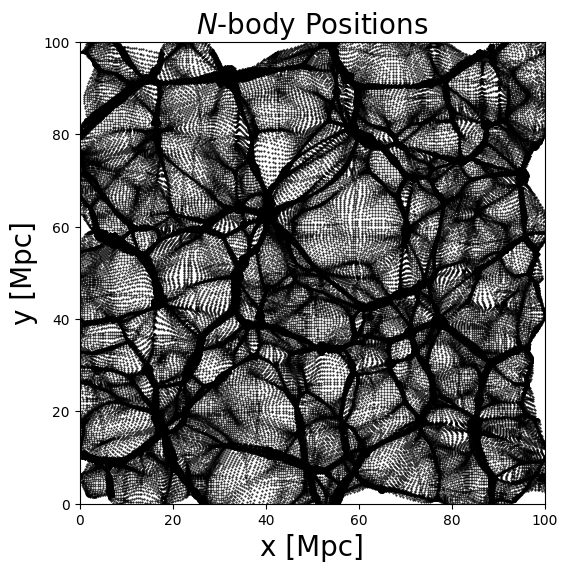

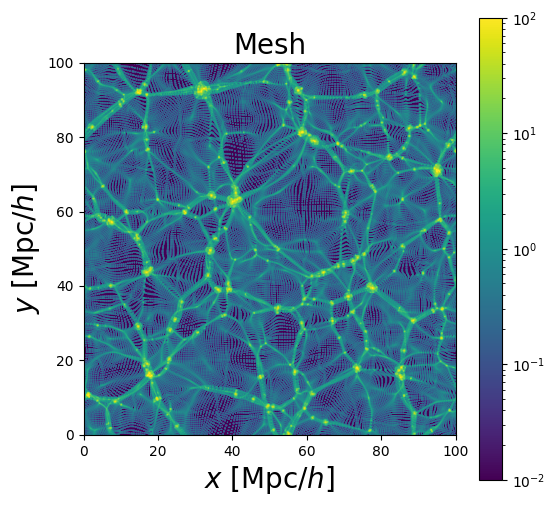

In [9]:
aini = 0.02
afin = 1. #0.03 #1
L = 100.
npart = 512 #64
ngrid = 512

myic = sim.ic.IC2DCosmo(npart, sigma8=0.8, L=L, aic=aini, rs=0.5, vec3d=True, Omega_m=1.)
mysim = sim.CosmologicalSimulation2d(myic, aic=aini, dafac_max=0.05, da_max=0.02, ngrid_pm=npart)
mysim.integrate_till(afin)
positions = mysim.pos.reshape(-1,2)
rho = sim.sim.deposit2d(mysim.pos, ngrid, myic.L, mode="cic")

fig, axs = plt.subplots(1,1, figsize=(6,6))
scatter = plt.scatter(positions[:,0], positions[:,1], marker=".", color="black",s=1)
#plt.colorbar(scatter, ax=axs, orientation="vertical", label=r"$\delta (a = 0.01)$")
axs.set_xlim(0,100)
axs.set_ylim(0,100)
axs.set_xlabel("x [Mpc]", size=20)
axs.set_ylabel("y [Mpc]", size=20)
plt.title(r"$N$-body Positions", size=20)
plt.show()

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(np.clip(rho / np.mean(rho), 1e-2, None).T, origin="lower", norm = LogNorm(vmin=1e-2, vmax=1e2), extent=[0,100.,0.,100.])
cbar = plt.colorbar(im, ax=ax)
plt.title("Mesh", size=20)
ax.set_xlabel(r"$x$ [Mpc/$h$]", fontsize=20)
ax.set_ylabel(r"$y$ [Mpc/$h$]", fontsize=20)
plt.show()

# Find the filaments

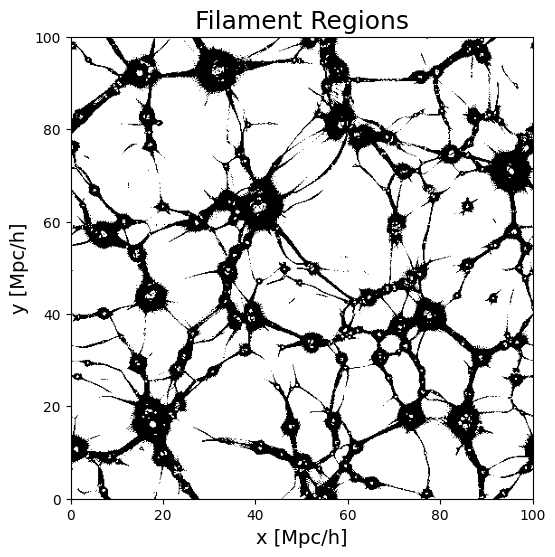

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftfreq
from matplotlib.colors import LogNorm

# 1. Grid info
N = ngrid #npart
Lbox = L
dx = Lbox / N

# 2. Overdensity field
delta = rho / np.mean(rho) - 1

# 3. FFT of density
delta_k = fft2(delta)
k = fftfreq(N, d=dx) * 2 * np.pi
kx, ky = np.meshgrid(k, k, indexing='ij')
k2 = kx**2 + ky**2
k2[0,0] = 1e-10  # avoid division by 0

# 4. Potential from Poisson equation
phi_k = -delta_k / k2

# 5. Second derivatives (tidal tensor in Fourier space)
Txx_k = -kx * kx * phi_k
Tyy_k = -ky * ky * phi_k
Txy_k = -kx * ky * phi_k

# 6. Inverse FFT to get back to real space
Txx = np.real(ifft2(Txx_k))
Tyy = np.real(ifft2(Tyy_k))
Txy = np.real(ifft2(Txy_k))

# 7. Eigenvalues of the 2x2 tidal tensor at each grid point
eigvals1 = np.zeros_like(delta)
eigvals2 = np.zeros_like(delta)

for i in range(N):
    for j in range(N):
        T = np.array([[Txx[i,j], Txy[i,j]],
                      [Txy[i,j], Tyy[i,j]]])
        eigs = np.linalg.eigvalsh(T)  # returns in ascending order
        eigvals1[i,j], eigvals2[i,j] = eigs

# 8. Filament criterion: both eigenvalues < threshold (negative values)
threshold = 1.  # or tune this empirically
# Only one eigenvalue below the threshold → filament
filaments = (eigvals1 < threshold) & (eigvals2 >= threshold)
#is_filament = eigvals1 < threshold

# 9. Plot
plt.figure(figsize=(7,6))
plt.imshow(filaments.T, origin="lower", extent=[0, Lbox, 0, Lbox], cmap="Greys")
plt.title("Filament Regions", fontsize=18)
plt.xlabel("x [Mpc/h]", fontsize=14)
plt.ylabel("y [Mpc/h]", fontsize=14)
plt.show()


# Find particles that belong to filaments

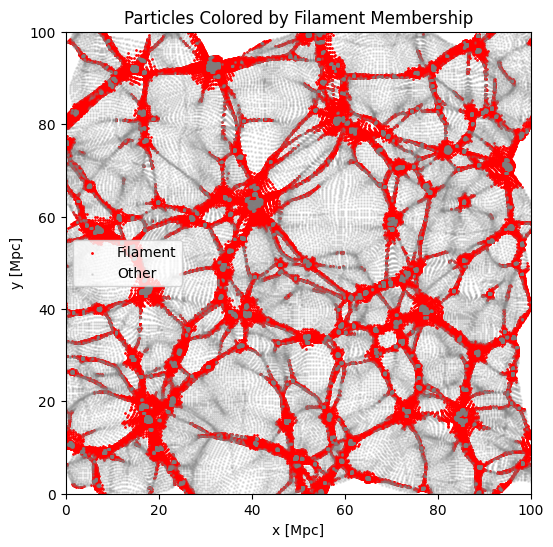

In [11]:
import matplotlib.pyplot as plt

# 1. Convert particle positions to grid indices
ngrid = filaments.shape[0]
cellsize = L / ngrid

# Normalize to grid
ix = (positions[:, 0] / cellsize).astype(int) % ngrid
iy = (positions[:, 1] / cellsize).astype(int) % ngrid

# 2. Use grid indices to extract mask value
is_filament_particle = filaments[ix, iy]

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(positions[is_filament_particle, 0],
           positions[is_filament_particle, 1],
           s=1, color='red', label='Filament')
ax.scatter(positions[~is_filament_particle, 0],
           positions[~is_filament_particle, 1],
           s=1, color='gray', alpha=0.2, label='Other')
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_xlabel('x [Mpc]')
ax.set_ylabel('y [Mpc]')
ax.legend()
plt.title('Particles Colored by Filament Membership')
plt.show()

# Find FoF Haloes 

Text(0, 0.5, '$y$ [Mpc/$h$]')

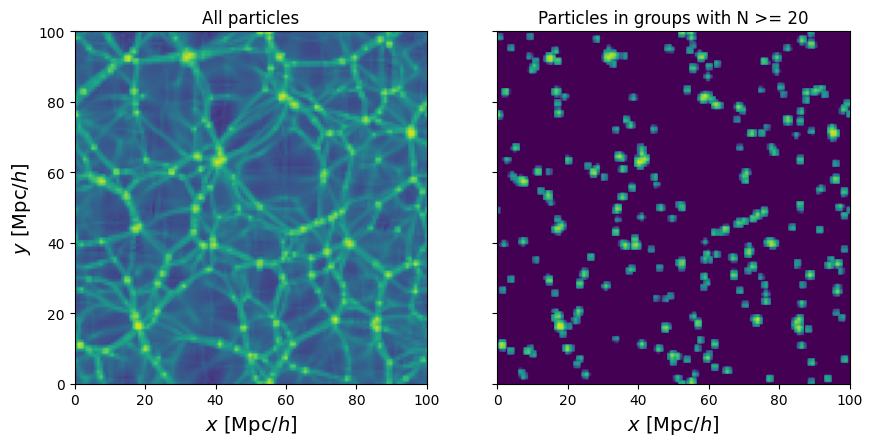

In [17]:
import pyfof

linking_length = 0.2*np.sqrt(np.mean(100.**2/512.**2))
res = pyfof.friends_of_friends(mysim.pos.reshape(-1,2), linking_length)

allids = []
for igroup,inds_in_group in enumerate(res):
    if len(inds_in_group) >= 20:
        allids += inds_in_group
allids = np.array(allids)


rho1 = sim.sim.deposit2d(mysim.pos, 128, myic.L, mode="cic")
rho2 = sim.sim.deposit2d(mysim.pos.reshape(-1,2)[allids], 128, myic.L, mode="cic")

fig, axs = plt.subplots(1,2, figsize=(10,5),sharey=True)
axs[0].imshow(np.clip(rho1 / np.mean(rho1), 1e-2, None).T, origin="lower", norm = LogNorm(vmin=1e-2, vmax=1e2), extent=[0,100.,0.,100.])
axs[1].imshow(np.clip(rho2 / np.mean(rho1), 1e-2, None).T, origin="lower", norm = LogNorm(vmin=1e-2, vmax=1e2), extent=[0,100.,0.,100.])
axs[0].set_title("All particles")
axs[1].set_title("Particles in groups with N >= 20");
for ax in axs:
    ax.set_xlabel(r"$x$ [Mpc/$h$]", fontsize=14)
axs[0].set_ylabel(r"$y$ [Mpc/$h$]", fontsize=14)


# Paint particles according to filament or halo belonging

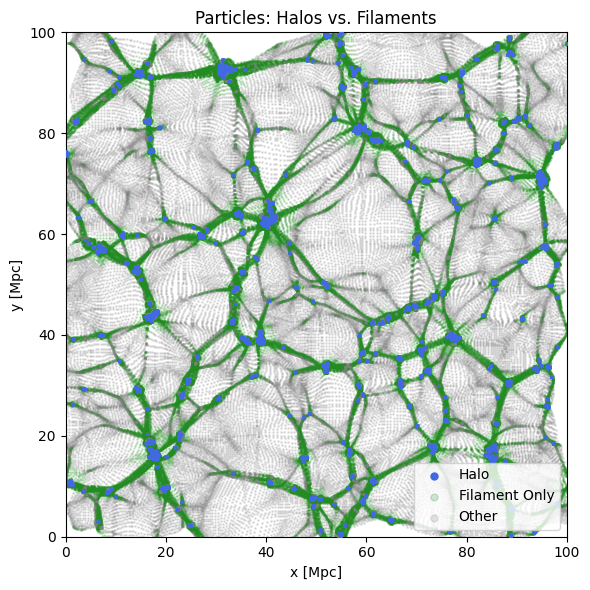

In [29]:
import numpy as np
import matplotlib.pyplot as plt

positions = mysim.pos.reshape(-1, 2)

# Create boolean masks
is_halo_particle = np.zeros(positions.shape[0], dtype=bool)
is_halo_particle[allids] = True

ngrid = filaments.shape[0]
cellsize = L / ngrid

# Grid indices
ix = (positions[:, 0] / cellsize).astype(int) % ngrid
iy = (positions[:, 1] / cellsize).astype(int) % ngrid
is_filament_particle = filaments[ix, iy]

# Adjusted masks
filament_only = is_filament_particle & ~is_halo_particle
background = ~is_filament_particle & ~is_halo_particle

# Plot
fig, ax = plt.subplots(figsize=(6, 6))

# 1. Halo particles (shown on top, in blue)
ax.scatter(positions[is_halo_particle, 0],
           positions[is_halo_particle, 1],
           s=1, color='royalblue', label='Halo', zorder=3)

# 2. Filament-only particles (red)
ax.scatter(positions[filament_only, 0],
           positions[filament_only, 1],
           s=1, color='forestgreen', alpha=0.2, label='Filament Only')

# 3. Background particles (gray)
ax.scatter(positions[background, 0],
           positions[background, 1],
           s=1, color='gray', alpha=0.2, label='Other')

# Final touches
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_xlabel('x [Mpc]')
ax.set_ylabel('y [Mpc]')
ax.legend(markerscale=5)
plt.title('Particles: Halos vs. Filaments')
plt.tight_layout()
plt.show()


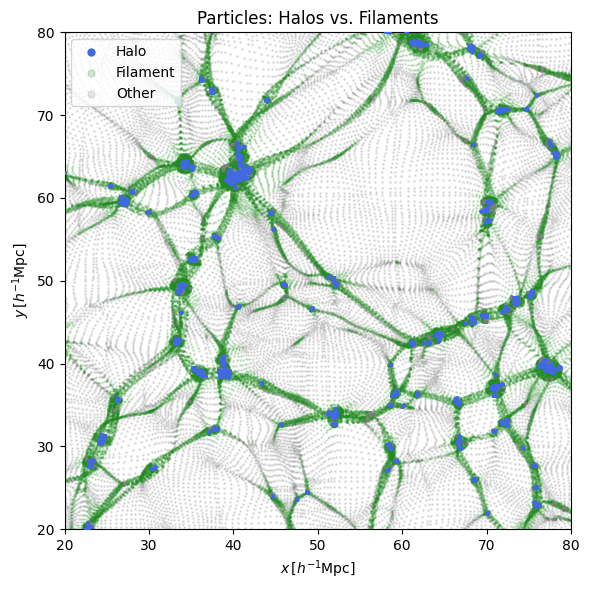

In [33]:
import numpy as np
import matplotlib.pyplot as plt

positions = mysim.pos.reshape(-1, 2)

# Create boolean masks
is_halo_particle = np.zeros(positions.shape[0], dtype=bool)
is_halo_particle[allids] = True

ngrid = filaments.shape[0]
cellsize = L / ngrid

# Grid indices
ix = (positions[:, 0] / cellsize).astype(int) % ngrid
iy = (positions[:, 1] / cellsize).astype(int) % ngrid
is_filament_particle = filaments[ix, iy]

# Adjusted masks
filament_only = is_filament_particle & ~is_halo_particle
background = ~is_filament_particle & ~is_halo_particle

# Plot
fig, ax = plt.subplots(figsize=(6, 6))

# 1. Halo particles (blue)
ax.scatter(positions[is_halo_particle, 0],
           positions[is_halo_particle, 1],
           s=1, color='royalblue', label='Halo', zorder=3)

# 2. Filament-only particles (green, translucent)
ax.scatter(positions[filament_only, 0],
           positions[filament_only, 1],
           s=1, color='forestgreen', alpha=0.2, label='Filament')

# 3. Background particles (gray)
ax.scatter(positions[background, 0],
           positions[background, 1],
           s=1, color='gray', alpha=0.2, label='Other')

# Zoom in
ax.set_xlim(20, 80)
ax.set_ylim(20, 80)

# Labels and legend
ax.set_xlabel(r'$x \, [h^{-1}{\rm Mpc]}$')
ax.set_ylabel(r'$y \, [h^{-1}{\rm Mpc]}$')
ax.legend(markerscale=5)
plt.title('Particles: Halos vs. Filaments')
plt.tight_layout()
plt.show()
